# Traffic Analysis Resistance: Dummy Traffic Privacy Analysis

Contact tracing applications (CT Apps) upload keys to a central server when users tested positive. These uploads, if done only after a positive test, would reveal the health status of users to a network observer that can observe the traffic generated by the app. To prevent this inference, CT Apps perform dummy uploads. 

Ideally, the observable variables of dummy and real uploads follow the same distribution. A network observer can then not distinguish real uploads from dummy uploads. Therefore, in the presence of dummy uploads, this network observer, cannot learn anything about the COVID-19 status of a user.

A real upload is composed of two server requests:
* The redeeming of a CovidCode at the CovidCode backend to obtain a signed token (respectively, tokens) that authorizes the app to upload keys to the SwissCovid red (respectively red and purple) servers.
* The upload of the keys to the SwissCovid red server and, optionally, check-in information to the SwissCovid purple server.

Between these two actions, the user needs to:
* Approve the release of keys for the Google and Apple Exposure Notification framework (press a button) for proximity tracing.
* Select the check-ins to be uploaded for Presence tracing.

Network observers can detect both network requests (obtaining the tokens, and retrieving the tokens), and therefore also measure the time between them. Dummy uploads must thus follow the same distribution as real uploads. However, the distribution of real uploads is not always known. In particular, there is no way of knowing (1) the *distribution of upload times* (i.e., the times when users initiate the upload process); and (2) the *distribution of inter-request times* (i.e., the time the user takes between redeeming the CovidCode and uploading). For the latter, this distribution may depend on prior user behaviour. For example, redacting visited locations likely takes longer if a user visited more locations. 

Due to this unkowns, dummy uploads *cannot perfectly* mimic real uploads.

* *Protecting the distribution of upload times*: A detailed proposal and privacy analysis regarding the distribution of upload times can be found in the [DP3T Best Practices document](https://github.com/DP-3T/documents/blob/master/DP3T%20-%20Best%20Practices%20for%20Operation%20Security%20in%20Proximity%20Tracing.pdf). The document proposes to sample dummy upload times from an exponential distribution and describes the request padding and response time padding to ensure that individual connections/requests in dummy and real uploads cannot be distinguished.

* *Protecting the distribution of upload times*: In this notebook we analyze the privacy leakage of inter-request times, and propose a delay distribution for real and dummy uploads to ensure plausible deniability with respect to network observers, even when the real behaviour of users is unknown.  

## Preliminaries
Library imports for computations and plotting

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

## Distinguishing single uploads

In the following we assume that on a single day, 50 people per million receive a positive test. In 2021 so far, the maximum number of positive tests in a day in Switzerland was 425 per million per day, and the minimum 29 per million per day. Since the current trend is downward, we assume a value on the lower end.

In [5]:
positives_per_million = 50

The question we want to answer is: "given an adversary's observation $\textrm{obs}$, what is the probability that the upload is real?". Ideally we would like this posterior probability to be equal to the prior probability that the upload is real.

Applying the Bayes' rule and the law of total probabilities, we obtain:

$$
P( \textrm{real} \mid \textrm{obs} ) = \frac{P(\textrm{obs} \mid \textrm{real}) p_{real}}{P(\textrm{obs})}
 = \frac{P(\textrm{obs} \mid \textrm{real}) p_{real}}{P(\textrm{obs} \mid \textrm{real}) p_{real} + P(\textrm{obs} \mid \textrm{fake}) (1 - p_{real})}
$$

The value $p_{real}$ is the prior probability of an upload being real. It depends on the actual number of positives per day and on the dummy rate. Given a value for  $p_{real}$ the posterior probability $P( \textrm{real} \mid \textrm{obs} )$ depends on the ratio between $P(\textrm{obs} \mid \textrm{real})$ and $P(\textrm{obs} \mid \textrm{fake})$. A rough approximation, assuming $p_{real}$ is small, tells us that

$$
P( \textrm{real} \mid \textrm{obs} ) \approx \frac{P(\textrm{obs} \mid \textrm{real})}{P(\textrm{obs} \mid \textrm{fake})}  p_{real}.
$$

This means that the more likely an observation is to have come from a real upload with respect to a fake upload, the larger the posterior probability and the easier it is for the adversary to identify correctly real updates. Our goal, as for the [distribution of upload time](https://github.com/DP-3T/documents/blob/master/DP3T%20-%20Best%20Practices%20for%20Operation%20Security%20in%20Proximity%20Tracing.pdf) is to ensure *plausible deniability*, i.e., we aim to keep the posterior probability $P( \textrm{real} \mid \textrm{obs} )$ small.

In the following graph we plot the posterior probability $P( \textrm{real} \mid \textrm{obs} )$ for different ratios and for different dummy rates (in number of dummies per day).

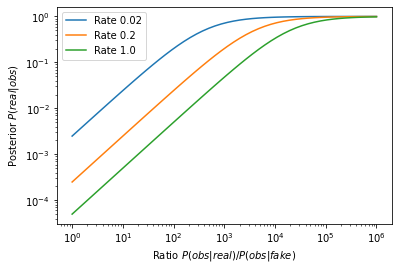

In [6]:
# r = P(obs | real) / P(obs | fake)
r = np.logspace(0,6)
dummyrates = [0.02, 0.2, 1.0]

for rate in dummyrates:
    p_real = positives_per_million / (positives_per_million + rate * 1e6)
    posterior = (r * p_real) / (r * p_real + (1 - p_real))
    plt.plot(r, posterior, label="Rate {}".format(rate))
    
plt.xscale("log")
plt.yscale("log")

plt.ylabel("Posterior $P(real|obs) $")
plt.xlabel("Ratio $P(obs|real) / P(obs|fake)$")
plt.legend()
plt.show()

To achieve plausible deniability we want the posterior probability to be less than 0.01. Setting $\textrm{ratio} = 
P(\textrm{obs} \mid \textrm{real}) / P(\textrm{obs} \mid \textrm{fake})$ and reworking the above equation, we obtain:
$$
\textrm{ratio} = \frac{\textrm{posterior}\cdot(1 - p_{real})}{(1 - \textrm{posterior}) \cdot p_{real}}
$$
where  $\textrm{posterior}=P( \textrm{real} \mid \textrm{obs} )$.

We express the dummy rate with the parameter $\lambda$. Feasible rates, i.e., those that do not cause huge overhead in the network, range from one per day ($\lambda = 1$) to once per 5 days ($\lambda = 0.2$). In SwissCovid, the dummy rate is $\lambda=0.2$. 

Evaluating the $\textrm{ratio}$ equation for $ P( \textrm{real} \mid \textrm{obs} ) = 0.01$ and the feasible dummy rates, we find the following maximum allowed ratios:

In [7]:
dummyrates = [0.2, 0.4, 1.0, 2.0]
posterior = 0.01

for rate in dummyrates:
    p_real = positives_per_million / (positives_per_million + rate * 1e6)
    max_ratio = posterior * (1 - p_real) / ((1 - posterior) * p_real)
    print("For dummy rate of {} maximum allowed ratio is {}".format(rate, max_ratio))

For dummy rate of 0.2 maximum allowed ratio is 40.4040404040404
For dummy rate of 0.4 maximum allowed ratio is 80.80808080808083
For dummy rate of 1.0 maximum allowed ratio is 202.02020202020202
For dummy rate of 2.0 maximum allowed ratio is 404.0404040404041


### The effect of different base rates

The actual ratio depends on the configured dummy rate and the current rate of positive diagnoses. The following graph shows the maximum allowed ratio for the current dummy rate of 1 per 5 days ($\lambda=0.2$) depending on the current positive diagnosis rate for three different posterior probabilities  $P( \textrm{real} \mid \textrm{obs} )$. We aim for  $P( \textrm{real} \mid \textrm{obs} )$ to be smaller than 0.01.

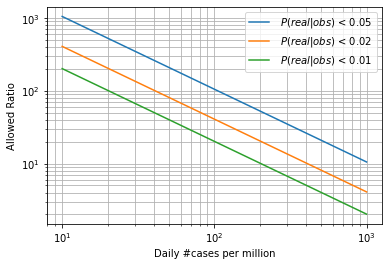

In [8]:
dummyrate = 0.2
diagnosis_rate = np.linspace(10, 1000, 100) # in positives per million

for posterior in [0.05, 0.02, 0.01]:
    preals = diagnosis_rate / (diagnosis_rate + dummyrate * 1e6)
    max_ratio = posterior * (1 - preals) / ((1 - posterior) * preals)
    plt.plot(diagnosis_rate, max_ratio, label=" $P(real|obs)$ < {}".format(posterior))

plt.xscale("log")
plt.yscale("log")
plt.ylabel("Allowed Ratio")
plt.xlabel("Daily #cases per million")
plt.legend()
plt.grid(True, which="both")
plt.show()

We see that for the maximum case load in 2021 (450 / million) the allowed ratio is only around 5 for a target posterior less than 0.01, and less than 30 for a target posterior below 0.05. If the maximum case load is smaller, e.g., 50 per million, or less, the ratio can grow considerably. 

## Distinguishing dummies and real after multiple observations

In SwissCovid, dummies are scheduled with exponential delay. Real uploads, however, are executed immediately. As we've seen in [earlier analyses](https://github.com/DP-3T/documents/blob/master/DP3T%20-%20Best%20Practices%20for%20Operation%20Security%20in%20Proximity%20Tracing.pdf), an adversary that observes a longer timespan -- and potentially observes several uploads -- can gather more evidence that a real upload happened based on the upload time. We now study how the adversary's inference power increases when they also have access to the inter-request timing.

Assume that the adversary observes the device (and the upload actions that it makes) for $D$ days. Let $N$ be the random variable denoting the number of uploads that the adversary observes during this time, and $O_1, \ldots, O_N$ the corresponding observations of the inter request timing of those uploads.

We define the probabilities $p_{\textrm{real}}$ (respectively $p_{\textrm{noreal}}$) to be the probability that the user makes a real upload within the observed $D$ days (respectively does not). These probabilities depend on the probability of a user testing positive on a given day and the number of observed days $D$ (observing for a larger number of days make $p_{\textrm{real}}$ grow). These probabilities *do not* depend on the dummy rate.

Let $P( \textrm{did REAL} )$ denote the probability that there indeed was a real upload among the observations, and $P( \textrm{no REAL} )$ the probability that there was no real upload. Applying Bayes' rule, we obtain:

$$
P( \textrm{did REAL} \mid obs = (N, O_1, \ldots, O_N)) =
  \frac{P( obs = (N, O_1, \ldots, O_N) \mid \textrm{did REAL}) \cdot p_{\textrm{real}}}{P( obs = (N, O_1, \ldots, O_N))}
$$

following the usual structure we need to compute: $P( obs = (N, O_1, \ldots, O_N) \mid \textrm{did REAL})$ and $P( obs = (N, O_1, \ldots, O_N) \mid \textrm{no REAL})$.

We assume that each of the $N$ observed uploads was equally likely to have been the real upload. Observations for each upload are independent, therefore we have that:

$$
P( obs = (N, O_1, \ldots, O_N) \mid \textrm{did REAL}) = \frac{P(\textrm{N - 1 dummy uploads})}{N} \sum_i \left[  P(O_i \mid \textrm{real upload}) \prod_{j\not= i} P(O_j \mid \textrm{dummy upload}) \right]
$$

And that:

$$
P( obs = (N, O_1, \ldots, O_N) \mid \textrm{no REAL}) = P(\textrm{N dummy uploads}) \prod_i P(O_i \mid \textrm{dummy upload})
$$

By choice of the exponential distribution we have that:
$$
P(\textrm{N dummy uploads}) = \frac{(D\lambda)^N e^{-D\lambda}}{N!}
$$
and
$$
P(\textrm{N - 1 dummy uploads}) = \frac{(D\lambda)^{N-1} e^{-D\lambda}}{(N-1)!}
$$

Plugging all of these into the Bayes' formula above and clearing common factors gives:
$$
P( \textrm{did REAL} \mid obs = (N, O_1, \ldots, O_N)) =
\frac{
  \sum_i \frac{P(O_i \mid \textrm{real upload})}{P(O_i \mid \textrm{dummy upload})} \cdot p_{\textrm{real}}
}{
  \sum_i \frac{P(O_i \mid \textrm{real upload})}{P(O_i \mid \textrm{dummy upload})} \cdot p_{\textrm{real}} +   
  D\lambda \cdot (1 - p_{\textrm{real}})
}
$$
given a maximum ratio $\textrm{ratio} = \frac{P(O_i \mid \textrm{real upload})}{P(O_i \mid \textrm{dummy upload})}$  this expression is upperbounded by
$$
P( \textrm{did REAL} \mid obs = (N, O_1, \ldots, O_N))
\leq
\frac{
  N \cdot \textrm{ratio} \cdot p_{\textrm{real}}
}{   
  D\lambda
}
= \frac{N\cdot\textrm{ratio}}{\lambda} p_{\textrm{day}}
$$
where $p_{\textrm{day}}$ is the probability that a user make a real upload in a given day (e.g., the probability that a user receives a positive test result on that day).

### How many samples would one expect?

We see that the posterior probability goes up as the number of observed samples goes up. However, the probability of observering so many samples also gets exceedingly rare.

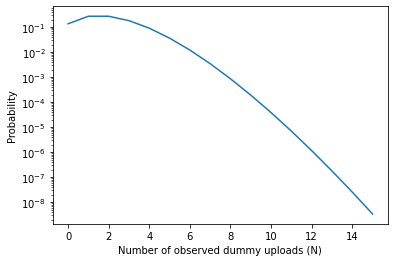

In [9]:
from scipy.stats import poisson

rate = 0.2
number_of_days = 10
mu = rate * number_of_days
xs = np.arange(0,16)
poisson_prob = poisson.pmf(xs, mu)

plt.plot(xs, poisson_prob)
plt.yscale("log")
plt.ylabel("Probability")
plt.xlabel("Number of observed dummy uploads (N)")
plt.show()

We see that the probability to observe 15 uploads over a observation period of 10 days is below 10^-8. In other words, less than 1 per 100 million users would exhibit this behaviour. The following computation confirms that even after seeing 20 uploads (which is extremely unlikely), the posterior probability is still bounded by 0.05.

In [10]:
p_day = positives_per_million / (positives_per_million + 1e6)
rate = 0.2
ratio = 10
N = 20
posterior_bound = ratio * N / rate * p_day

posterior_bound

0.04999750012499375

## Bounding the posterior probability

We have that the posterior probability $P( \textrm{did REAL} \mid obs = (N, O_1, \ldots, O_N))$ is bounded by:

$$
P( \textrm{did REAL} \mid obs = (N, O_1, \ldots, O_N)) \leq \frac{N\cdot\textrm{ratio}}{\lambda} p_{\textrm{day}}
$$

We also have that the number of observed uploads $N$ is typically small, and the dummy rate $\lambda$ and the probability of receiving a positive diagnosis on a given day $p_{\textrm{day}}$ are constants. The other term that influences the posterior is the $\textrm{ratio}= \frac{P(O_i \mid \textrm{real upload})}{P(O_i \mid \textrm{dummy upload})}$. 

We now analyze the worst case scenario for this $\textrm{ratio}$, and use it to propose a distribution of delays in the inter-request time that ensures the ratio is kept small -- and thus the posterior is small. 

### Distinguishing real and dummy traffic: worst case scenario

The ratio $\frac{P(O_i \mid \textrm{real upload})}{P(O_i \mid \textrm{dummy upload})}$ is largest when the numerator is large while the denominator is small; e.g. when an observation is very likely to occur for a real upload by unlikely to occur for a dummy upload.

In our scenario, observations consists of the inter-request time of an upload action. In theory, the ratio can be unbounded. Assume the (unlikely) case that real uploads induce the exact same inter-request time and that the inter-request time of dummy actions follow a continuous distribution whose support has non-zero measure. Then if $\textrm{obs}$ equals the inter-request time of real uploads, the numerator will equal 1, will the denominator will equal 0. 

While this scenario is extreme, very large ratios can definitely occur in practice when the inter-request time distribution of real actions is unknown. (If it is known, one would simply sample dummy inter-request times from that same distribution.) For example, when all real actions induce an inter-request time between 5 and 6 seconds, whereas dummy requests have an inter-request time that is uniformly random between 0 and 300 seconds. Then for $\textrm{obs} = 5 \leq \textrm{inter-request time} \leq 6$ the ratio would turn out to be 300.

### Preventing the worst case

In order to prevent the concentration of probability mass around certain values, the app can add a small uniform random delay to real user actions. This extra delay effectively smooths out the distribution of inter-request times. This in turn, ensures that the ratio stays bounded as long as the support of the inter-request times distribution used for dummy actions is infinite.

For instance, adding a small uniform delay of 5 seconds already makes a big difference. For the previous example. With such a delay, when the IRT is less than 3 minutes (i.e., 180 seconds), the maximum ratio for an observation of duration $T$ would be at most:

$$
ratio = \frac{P(\textrm{obs} \mid \textrm{real})}{P(\textrm{obs} \mid \textrm{fake})}
      \leq \frac{T / 5}{T / 180} \leq \frac{1}{36}.
$$

Of course, the ratio would still be unbounded when the observed inter-request time is more than 3 minutes.

### Preventing the worst case without information on the real distribution

We use the above results to design a dummy upload mechanism that provides plausible deniability for a wide variety of inter-request time distributions for real uploads. We make the following assumptions:

 * Real users complete the upload action within 3 minutes (or alternatively; we do not provide protection for users that take longer)
 
We deploy the following mechanism, in which uploads are triggered according to an [exponential distribution](https://github.com/DP-3T/documents/blob/master/DP3T%20-%20Best%20Practices%20for%20Operation%20Security%20in%20Proximity%20Tracing.pdf):

 * *Real uploads*: After redeeming the CovidCode, we delay real user uploads by an additional uniform delay of at most 5 seconds
 * *Dummy uploads*: we use the following distribution to sample inter-request delays of dummy uploads
   * A uniform distribution on $[0,180)$ seconds.
   
As a result of these choices, the ratio for requests less than 3 minutes (180 seconds) is below 60 for any distribution that satisfies the above constraints. To see why, note that the probability density of the real distribution is at most $1/5$, whereas the density of the corresponding dummy distribution is constantly $1/180$. The ratio is thus 36. At this configuration, the posterior probability stays below 0.01.

Initial experiments show that the probability mass is more likely to peak at a value between $0.1$ and $0.05$ (e.g. given an interval of length $T$, the probability of observing a sample from that interval is upperbounded by $0.1T$ respectively $0.05T$). In that case, the ratio drops to 18 respectively 9.

Near these design points, the posterior roughly scales linear with the base-rate. If the number of daily cases doubles to 100 per million, the posteriors also double. If the daily cases keep dropping, the posteriors will also drop.

*No protection for long user delays.* It is conceivable that some users require more than 3 minutes to complete the entire upload process. With the above configuration, these users are not protected against network observers. In theory, we could extend the support of the distribution for dummy uploads beyond 3 minutes so as to also provide protection for these users. However, the mobile operating systems, and in particular iOS, prohibit long-running background tasks. Dummy uploads can therefore have a delay of at most 3 minutes.

### Collecting information on the real distribution to adjust the dummy strategy

We propose to estimate the real distributions based on real uploads while the temporary mechanism is in place. To do so, whenever an app makes a real upload, it also reports the (non-delayed) time it took the user to go from entering the COVID code to completing the final step in the upload process. The backend server will report in the database the day of upload as well as the reported time.

We can then measure the true distribution. Based on the current rate at which COVID codes are entered, we estimate that to obtain reliable statistics, one needs to collect inter-request times for at least two weeks.

We therefore propose the following approach:

 1. Initially run with the temporary distribution described above
 2. After two weeks, determine if the observed times match a known distribution easy to sample from. If not, estimate the distribution using a simple step function, and evaluate the ratio between the estimated distribution and the observed distribution to evaluate the new protection level.
 4. Use the configuration server to inform clients to generate dummy traffic using the new distribution
 5. Repeat 3 and 4 every week to reflect changes in user behaviour.
 
## Security against snapshot attackers

As part of the [Best Practices](https://github.com/DP-3T/documents/blob/master/DP3T%20-%20Best%20Practices%20for%20Operation%20Security%20in%20Proximity%20Tracing.pdf) to protect privacy, it is important to ensure that any information that is stored permanently on the backend servers cannot be used by an adversary to retroactively reveal COVID-19 status.

Log files typically reveal which IP address queried which endpoint when. An adversary getting access to a snapshot of the state of the server can access log files and databases. This attacker can use the log files to learn at what time a user from a given IP address queries a given endpoint. Because to perform an upload users need to access the servers twice (one to redeem the CovidCode and once to upload information to the backend server), this adversary can also compute the inter arrival time (IAT) between these two requests. Therefore, the snapshot attacker can apply the same inferences as a network observer to try to assign a probability that a given uploads is real.

A snapshot attacker, has access to more information than the network adversary. Th snapshot adversary also has a snapshot of the databases of the backend servers. In particular they can access:

1. The database of uploaded TEKs. Every row in this database is tagged with the 2-hour time interval during which the corresponding TEKs have been uploaded.
2. The database of uploaded check-in information. As for the TEK database, every upload is tagged with the 2-hour time interval during which the corresponding tracing keys have been uploaded.
3. The database of app-reported user interaction times collected to improve dummy traffic. Each row in this database is tagged with the day in which the interaction time was collected.

We first explore what an attacker could do with only access to the databases of uploaded TEKs and venue information. The adversary can use the informaiton in this database to determine the number $M$ of *real* uploads that took place in each 2-hour window. This reveals that $M$ of the logged IPs in those two hours actions must have been real uploads. Based on the current rate of dummy traffic, we estimate that the log file contains on average 33k entries every two hours (assuming 2M active users). Therefore, the anonymity set of each upload is around 33k.

An adversary that also has access to the database of user interaction times, can reduce this anonymity set. Entries in this interaction-time database not only reveal that an upload was made during a given day, but also provide a bound on the inter-arrival time (IAT) of that upload. Recall that when users are doing a real upload, apps add a uniformly random delay of at most 5 seconds between receiving a token and making the upload. This means that, for example, a reported user-interaction time of 12 seconds can only correspond to uploads with an observed IAT of 12 to 17 seconds (ignoring network latencies, which are likely small). Thus, the adversary can discard any IP address whose IAT is not in this interval.

A snapshot attacker that uses the interaction time database and logs only (i.e., not the TEK or tracing key database) needs to consider, for a given entry with user-interaction time, all uploads _on the same day_ whose IAT is at most 5 seconds longer than the value in the database. Assume 2M users, the standard dummy rate, and the default random dummy IAT delay of at most 180 seconds. For a given 5 seconds interval, we expect to see

$$
400.000 \cdot \frac{5}{180} \approx 11111
$$

dummy uploads with an IAT that matches the stored user-interaction time. The anonymity set is thus around 11k.

In the worse case, however, the snapshot attacker combines both databases. Assume that the user-interaction time database only contains one entry for a given day. The attacker can then determine during which 2-hour time window this upload was made by determining which bucket of TEKs / checkin-information is non-empty. As a result, the anonymity set for this particular upload consists of uploads that were (1) made during this 2-hour window, and (2) have an IAT that is at most 5 seconds larger. Combining these facts, results in an anonymity set of just under one thousand uploads.